# 0.0 Imports

In [1]:
import warnings
import numpy as np
import pandas as pd
import seaborn as sns

from matplotlib import pyplot as plt
from sklearn import model_selection as ms
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error

## 0.1 Load data

In [2]:
exploratory_data_analysis = catalog.load("exploratory_data_analysis")
train_feature_selection = catalog.load("train_feature_selection")
validation_feature_selection = catalog.load("validation_feature_selection")
yeojohnson_transformation = catalog.load("yeojohnson_transformation")

[09/24/23 11:51:54] INFO     Loading data from 'exploratory_data_analysis' (CSVDataSet)...      ]8;id=24560;file://f:\SamuelOliveiraAlvesd\Anaconda3\envs\netflix_classifier\Lib\site-packages\kedro\io\data_catalog.py\data_catalog.py]8;;\:]8;id=509548;file://f:\SamuelOliveiraAlvesd\Anaconda3\envs\netflix_classifier\Lib\site-packages\kedro\io\data_catalog.py#492\492]8;;\

                    INFO     Loading data from 'train_feature_selection' (CSVDataSet)...        ]8;id=565685;file://f:\SamuelOliveiraAlvesd\Anaconda3\envs\netflix_classifier\Lib\site-packages\kedro\io\data_catalog.py\data_catalog.py]8;;\:]8;id=160916;file://f:\SamuelOliveiraAlvesd\Anaconda3\envs\netflix_classifier\Lib\site-packages\kedro\io\data_catalog.py#492\492]8;;\

                    INFO     Loading data from 'validation_feature_selection' (CSVDataSet)...   ]8;id=685027;file://f:\SamuelOliveiraAlvesd\Anaconda3\envs\netflix_classifier\Lib\site-packages\kedro\io\data_catalog.py\data_catalog.py]8;;\:]8;id=511679;file://f:\SamuelOliveiraAlvesd\Anaconda3\envs\netflix_classifier\Lib\site-packages\kedro\io\data_catalog.py#492\492]8;;\

                    INFO     Loading data from 'yeojohnson_transformation' (PickleDataSet)...   ]8;id=190768;file://f:\SamuelOliveiraAlvesd\Anaconda3\envs\netflix_classifier\Lib\site-packages\kedro\io\data_catalog.py\data_catalog.py]8;;\:]8;id=211160;file://f:\SamuelOliveiraAlvesd\Anaconda3\envs\netflix_classifier\Lib\site-packages\kedro\io\data_catalog.py#492\492]8;;\

## 0.2 Helper Functions

In [3]:
def notebook_settings():
    pd.set_option('display.max_columns', None)
    pd.set_option('display.max_rows', 60)
    pd.set_option('display.float_format', lambda x: '%.3f' % x)

    plt.style.use('bmh')
    plt.rcParams['figure.figsize'] = [25,12]
    plt.rcParams['font.size'] = 24
    sns.set()

    warnings.filterwarnings('ignore')
    return None


def ml_error(model_name, y, yhat):
    mae = mean_absolute_error(y, yhat)
    rmse = np.sqrt(mean_squared_error(y, yhat))
    
    return pd.DataFrame({'Model Name': model_name,
                         'MAE' : mae,
                         'RMSE': rmse}, index=[0])


def yeojohnson_inverse(y):
    lambda_val = yeojohnson_transformation.value
    
    y_positive_mask = y >= 0
    y_negative_mask = ~y_positive_mask

    result = np.empty_like(y)

    if lambda_val == 0:
        result[y_positive_mask] = np.exp(y[y_positive_mask]) - 1
        result[y_negative_mask] = -np.exp(-y[y_negative_mask]) - 1
    elif lambda_val != 0:
        result[y_positive_mask] = (lambda_val * y[y_positive_mask] + 1) ** (1 / lambda_val) - 1
        result[y_negative_mask] = -((-lambda_val * y[y_negative_mask] + 1) ** (1 / -lambda_val) - 1)

    return result


notebook_settings()

# 7.0 Translation and interpretation of the error

In [4]:
cols_drop = ['show_id', 'date_added', 'rating']

# training dataset
y_train = train_feature_selection['rating']
x_train = train_feature_selection.drop(cols_drop, axis=1)

# validation dataset
y_val = validation_feature_selection['rating']
x_val = validation_feature_selection.drop(cols_drop, axis=1)

# model
lr = LinearRegression().fit(x_train, y_train)

# prediction
yhat_lr = lr.predict(x_val)

bussiness_performance = validation_feature_selection.copy()

# rescale
bussiness_performance['predictions'] = yeojohnson_inverse(yhat_lr)

## 7.1 Bussiness Performance

In [5]:
mae_error = bussiness_performance[['show_id', 'rating', 'predictions']].groupby('show_id').apply(lambda x: mean_absolute_error( x['rating'], x['predictions'])).reset_index().rename(columns={0:'MAE'})

bussiness_performance = pd.merge(bussiness_performance, mae_error, how='inner', on='show_id')

# Scenarios
bussiness_performance['worst_scenario'] = bussiness_performance['predictions'] - bussiness_performance['predictions'].std()
bussiness_performance['best_scenario'] = bussiness_performance['predictions'] + bussiness_performance['predictions'].std()

# order columns
bussiness_performance = bussiness_performance.sort_values('MAE', ascending=False)

bussiness_performance[['show_id', 'rating', 'predictions', 'worst_scenario', 'best_scenario', 'MAE']]

,show_id,rating,predictions,worst_scenario,best_scenario,MAE
9,81091424,0,71.359,67.281,75.437,71.359
548,80204118,0,70.262,66.184,74.340,70.262
725,80204117,0,70.262,66.184,74.340,70.262
274,80168198,0,69.485,65.407,73.563,69.485
778,70050576,0,67.873,63.795,71.950,67.873
...,...,...,...,...,...,...
417,80097530,61,60.954,56.876,65.031,0.046
379,80199806,65,64.955,60.878,69.033,0.045
539,80082660,60,59.978,55.901,64.056,0.022
577,80128690,59,59.016,54.938,63.094,0.016


- Here we sort for the largest errors, so we can demonstrate that there will naturally be situations in which the model fails to capture that behavior. The best/worst case scenario construction can also be useful when the business team seeks to relate its decisions to other factors in order to underestimate or overestimate.

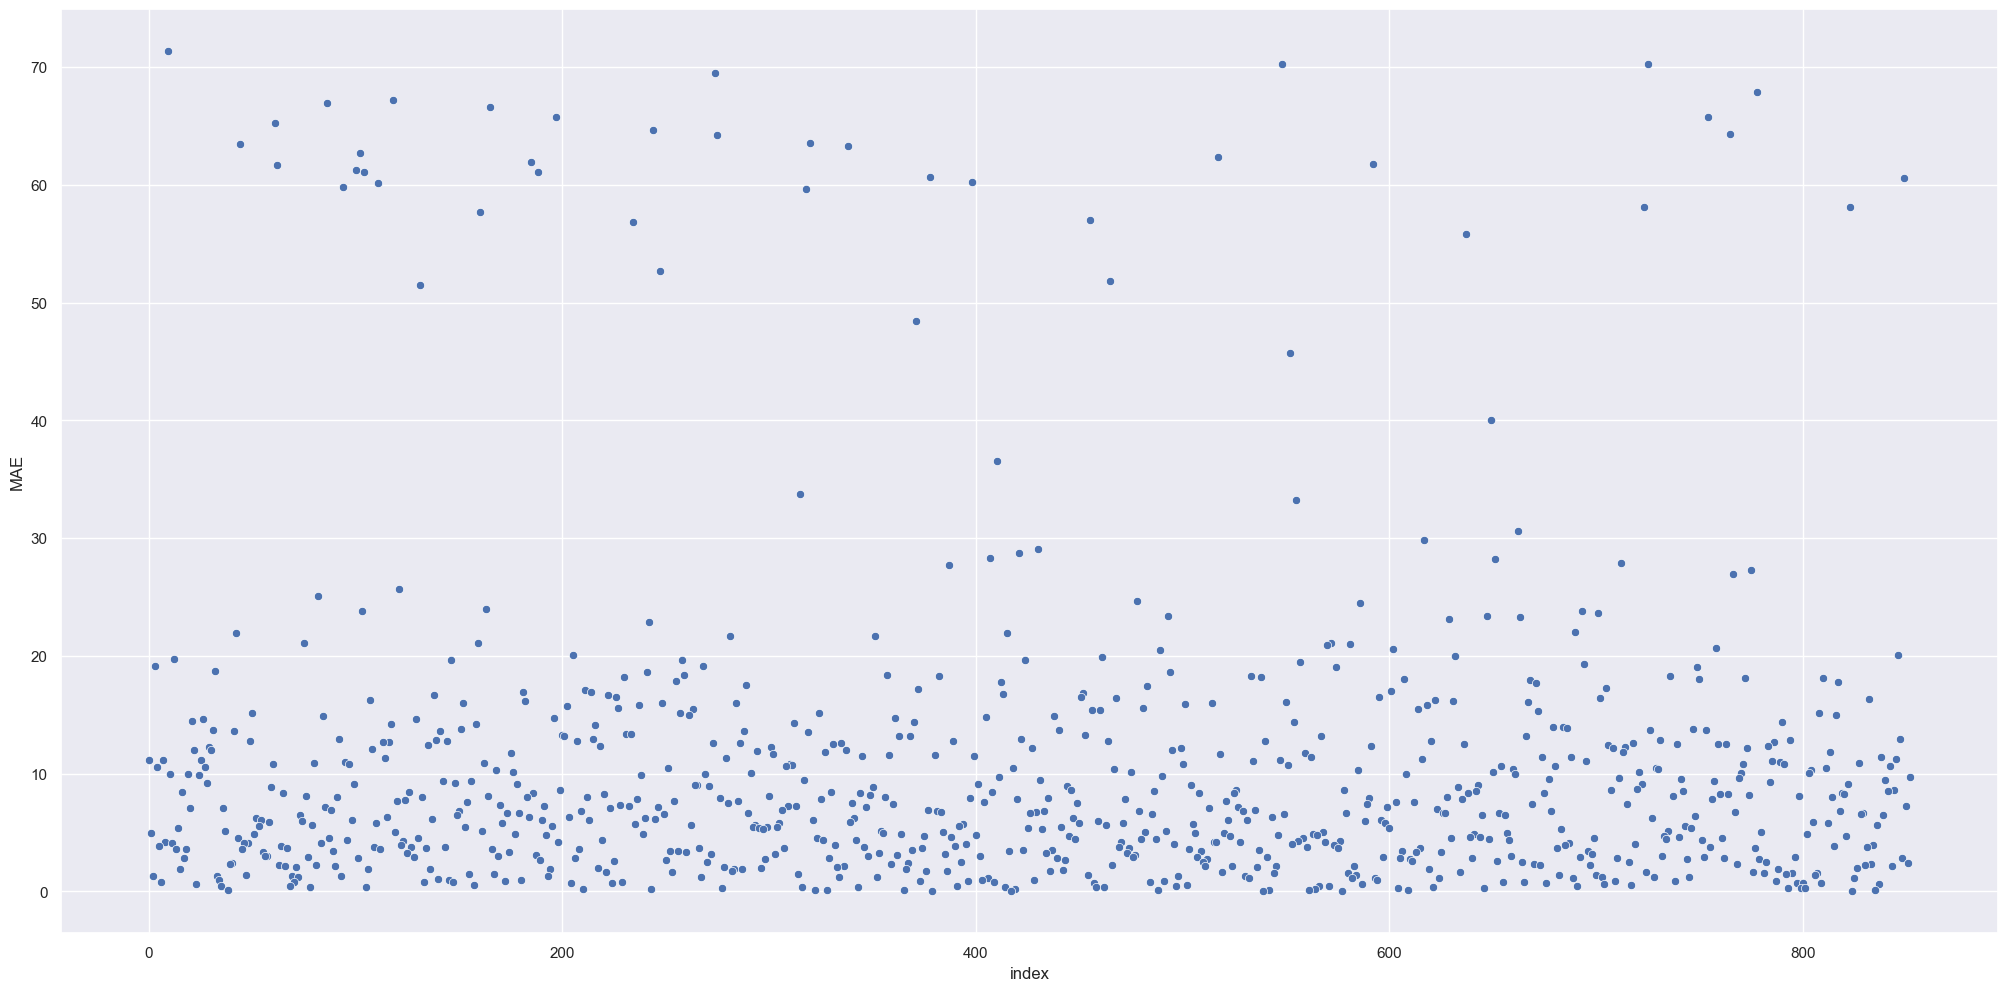

In [6]:
sns.scatterplot(x='index', y='MAE', data=bussiness_performance.reset_index());

- This visualization only emphasizes the information of films that have considerable errors, but overall the error is well concentrated in small values.

### 7.1.1 Total Performance

In [7]:
total_performance = bussiness_performance[['predictions', 'worst_scenario', 'best_scenario']].apply(lambda x: np.mean(x), axis=0).reset_index().rename(columns={'index': 'Scenario', 0:'Values'})
total_performance

,Scenario,Values
0,predictions,63.692
1,worst_scenario,59.614
2,best_scenario,67.770


- Finally, we see that the predictions are averaging a score of 63, which could be a benchmark for becoming the minimum score to consider a good movie in the future, but we'll go into this more in the next topic.

## 7.2 Business scenarios

- First we'll build the planning output, here we'll select films that haven't been released and extract those with scores over 50

In [8]:
# Collect dataframe with pre-transformed features
X = exploratory_data_analysis.drop('rating', axis=1)
y = exploratory_data_analysis['rating'].copy()

_, x_val, _, y_val = ms.train_test_split(X, y, test_size=0.20)

validation_data = pd.concat([x_val, y_val], axis=1)

bussiness_scenario = validation_data.merge(bussiness_performance[['show_id', 'predictions']], how='inner', on='show_id')

# filter out unreleased films with a score above 50
prioritized_films = bussiness_scenario[pd.to_datetime(bussiness_scenario['date_added']).dt.year <= bussiness_scenario['release_year']]
prioritized_films = prioritized_films[prioritized_films['predictions'] > 50][['show_id', 'predictions']]

print('Here we can see that filtering out the right films and applying a score higher than '
      f'50 optimizes the choice to approximately: {prioritized_films.shape[0] / bussiness_scenario.shape[0] * 100:.2f}% of the catalog.')

Here we can see that filtering out the right films and applying a score higher than 50 optimizes the choice to approximately: 26.38% of the catalog.


- we have a situation where, out of 162 films, 47 meet the criterion of films in production, but when we analyze those that score higher than the minimum, we see that they all meet it, and here we can develop a resource optimization scenario

### 7.2.1 Case 1: optimization of fixed resources

- Suppose that each film costs on average `$100,000.00` and Netflix has a budget for the next period of `$3,400,000.00` in this scenario it wants to understand the best allocation of resources and we can do this by prioritizing the films with the best ratings

In [9]:
total_budget = 3400000
cost_per_film = 100000
qty_of_films = total_budget/cost_per_film

selected_films = bussiness_scenario.sort_values('predictions', ascending=False).head(int(qty_of_films)).shape[0]

print(f'The number of films that meet the criteria is: {selected_films}')

The number of films that meet the criteria is: 34


- In this situation we have an allocation of 34 films, which corresponds to an allocation of 72.34% of the planned films compared to the previous scenario, in practical terms the rest could be paused or canceled.
- It's understandable that fixed-budget scenarios aren't realistic, so let's use studies to enrich our scenarios.

### 7.2.2 Case 2: Optimization by production cost and expected return

Based on a study carried out on [The Numbers](https://www.the-numbers.com/movies/#tab=genre), it was possible to establish a list of average production costs and worldwide revenue by film genre. Below, we list the genres and the associated values:

| Genre | Average Cost of Production | Worldwide Revenue
|---------------------|-------------------------|--------------------|
| Adventure           | $72,413,501             | $195,210,626,643   |
| Action              | $66,873,473             | $186,573,340,859   |
| Drama               | $18,698,653             | $115,717,604,152   |
| Comedy              | $22,615,729             | $95,882,821,942    |
| Thriller/Suspense   | $29,033,251             | $55,440,731,810    |
| Horror              | $15,062,701             | $35,774,078,806    |
| Romantic Comedy     | $23,793,890             | $29,079,548,547    |
| Musical             | $31,162,193             | $14,893,293,524    |
| Black Comedy        | $18,350,542             | $6,389,523,983     |
| Documentary         | $3,264,743              | $5,684,715,626     |
| Western             | $25,682,218             | $4,623,107,618     |
| Concert/Performance | $8,698,929              | $1,058,282,221     |
| Multiple Genres     | $27,330,000             | $586,209,859       |
| Reality             | $10,000,000             | $143,688,232       |
| Educational         | $0                      | $36,091,208        |
| Instructional       | $0                      | $267               |

- In this situation we can group the netlifx films by category and use the production cost in the scenarios as well as analyze the opportunity cost based on the average revenue.

In [10]:
# For simplicity's sake, let's just map out the first genres of each movie
# Mapping the categories to the genres from The Numbers
budget_mapping = {
    "Documentaries": "Documentary",
    "Comedies, Dramas, International Movies": "Comedy",
    "Documentaries, International Movies": "Documentary",
    "Dramas, Independent Movies, International Movies": "Drama",
    "Comedies": "Comedy",
    "Dramas, International Movies": "Drama",
    "Dramas, International Movies, Thrillers": "Drama",
    "Comedies, International Movies, Romantic Movies": "Comedy",
    "Comedies, Dramas, Independent Movies": "Comedy",
    "Action & Adventure, Dramas, International Movies": "Action",
    "Stand-Up Comedy": "Comedy",
    "Action & Adventure, International Movies": "Action",
    "Action & Adventure, Comedies, International Movies": "Action",
    "Dramas, International Movies, Music & Musicals": "Drama",
    "Dramas, Independent Movies": "Drama",
    "Children & Family Movies, Comedies": "Comedy",
    "Dramas": "Drama",
    "Dramas, Thrillers": "Drama",
    "Action & Adventure, Comedies": "Action",
    "Children & Family Movies": "Adventure"
}

bussiness_scenario['grouped_genres'] = bussiness_scenario['listed_in'].map(budget_mapping).fillna('Others_genres')

# Dictionary with average production values by genre
production_budget_dict = {
    "Adventure": 72413501,
    "Action": 66873473,
    "Drama": 18698653,
    "Comedy": 22615729,
    "Thriller/Suspense": 29033251,
    "Horror": 15062701,
    "Romantic Comedy": 23793890,
    "Musical": 31162193,
    "Black Comedy": 18350542,
    "Documentary": 3264743,
    "Western": 25682218,
    "Concert/Performance": 8698929,
    "Multiple Genres": 27330000,
    "Reality": 10000000,
    "Educational": 0,
    "Instructional": 0
}

# Dictionary of worldwide revenue figures by gender
worldwide_box_office_dict = {
    "Adventure": 195210626643,
    "Action": 186573340859,
    "Drama": 115717604152,
    "Comedy": 95882821942,
    "Thriller/Suspense": 55440731810,
    "Horror": 35774078806,
    "Romantic Comedy": 29079548547,
    "Musical": 14893293524,
    "Black Comedy": 6389523983,
    "Documentary": 5684715626,
    "Western": 4623107618,
    "Concert/Performance": 1058282221,
    "Multiple Genres": 586209859,
    "Reality": 143688232,
    "Educational": 36091208,
    "Instructional": 267
}

# Map the values to the dataframe based on the 'grouped_genres' column
bussiness_scenario['average_production_budget'] = bussiness_scenario['grouped_genres'].map(production_budget_dict)
bussiness_scenario['worldwide_box_office'] = bussiness_scenario['grouped_genres'].map(worldwide_box_office_dict)

bussiness_scenario['average_production_budget'] = bussiness_scenario['average_production_budget'].fillna(bussiness_scenario['average_production_budget'].mean())
bussiness_scenario['worldwide_box_office'] = bussiness_scenario['worldwide_box_office'].fillna(bussiness_scenario['worldwide_box_office'].mean())

Let's analyze the results in three situations:

### Scenario 1: Simple Selection
In this scenario, we will simply sort the movies by the predicted score and keep selecting until the budget runs out.

### Scenario 2: Simple Optimization
We'll select the films with the best relationship between predicted score and cost.

### Scenario 3: Optimization with Opportunity Cost
Let's consider both the relationship between predicted score and cost, and the revenue expected from the film (in relation to its cost).

In [11]:
# Defining budgets
min_budget = bussiness_scenario['average_production_budget'].min()

mean_budget = bussiness_scenario['average_production_budget'].mean()

one_fourth_max_budget = bussiness_scenario['average_production_budget'].sum() / 4

one_third_max_budget = bussiness_scenario['average_production_budget'].sum() / 3

half_max_budget = bussiness_scenario['average_production_budget'].sum() / 2

three_quarters_max_budget = bussiness_scenario['average_production_budget'].sum() * 0.75

max_budget = bussiness_scenario['average_production_budget'].sum()

budget_list = sorted([min_budget, mean_budget, one_fourth_max_budget, 
                      one_third_max_budget, half_max_budget, three_quarters_max_budget, 
                      max_budget])

selected_counts_c1 = []
selected_counts_c2 = []
selected_counts_c3 = []
average_rate_c1 = []
average_rate_c2 = []
average_rate_c3 = []

for budget in budget_list:
    # Sorting the dataframe by the 'predictions' column in descending order
    bussiness_scenario_sorted = bussiness_scenario.sort_values(by='predictions', ascending=False)

    # Scenario 1: Simple Selection
    selected_movies_c1 = []
    remaining_budget_c1 = budget

    for index, row in bussiness_scenario_sorted.iterrows():
        if row['average_production_budget'] <= remaining_budget_c1:
            selected_movies_c1.append(row)
            remaining_budget_c1 -= row['average_production_budget']
        if remaining_budget_c1 <= 0:
            break

    df_selected_c1 = pd.DataFrame(selected_movies_c1)

    # Scenario 2: Simple Optimization
    bussiness_scenario_sorted['prediction_cost_ratio'] = bussiness_scenario_sorted['predictions'] / bussiness_scenario_sorted['average_production_budget']

    selected_movies_c2 = []
    remaining_budget_c2 = budget

    for index, row in bussiness_scenario_sorted.sort_values(by='prediction_cost_ratio', ascending=False).iterrows():
        if row['average_production_budget'] <= remaining_budget_c2:
            selected_movies_c2.append(row)
            remaining_budget_c2 -= row['average_production_budget']
        if remaining_budget_c2 <= 0:
            break

    df_selected_c2 = pd.DataFrame(selected_movies_c2)

    # Scenario 3: Optimization with Opportunity Cost
    bussiness_scenario_sorted['opportunity_cost'] = bussiness_scenario_sorted['worldwide_box_office'] / bussiness_scenario_sorted['average_production_budget']
    bussiness_scenario_sorted['combined_score'] = bussiness_scenario_sorted['predictions'] * bussiness_scenario_sorted['opportunity_cost']

    selected_movies_c3 = []
    remaining_budget_c3 = budget

    for index, row in bussiness_scenario_sorted.sort_values(by='combined_score', ascending=False).iterrows():
        if row['average_production_budget'] <= remaining_budget_c3:
            selected_movies_c3.append(row)
            remaining_budget_c3 -= row['average_production_budget']
        if remaining_budget_c3 <= 0:
            break

    df_selected_c3 = pd.DataFrame(selected_movies_c3)

    # Store the number of movies selected
    selected_counts_c1.append(len(df_selected_c1))
    selected_counts_c2.append(len(df_selected_c2))
    selected_counts_c3.append(len(df_selected_c3))

    # Calculates the average rate for each scenario
    average_rate_c1.append(df_selected_c1['worldwide_box_office'].sum() / df_selected_c1['average_production_budget'].sum())
    average_rate_c2.append(df_selected_c2['worldwide_box_office'].sum() / df_selected_c2['average_production_budget'].sum())
    average_rate_c3.append(df_selected_c3['worldwide_box_office'].sum() / df_selected_c3['average_production_budget'].sum())

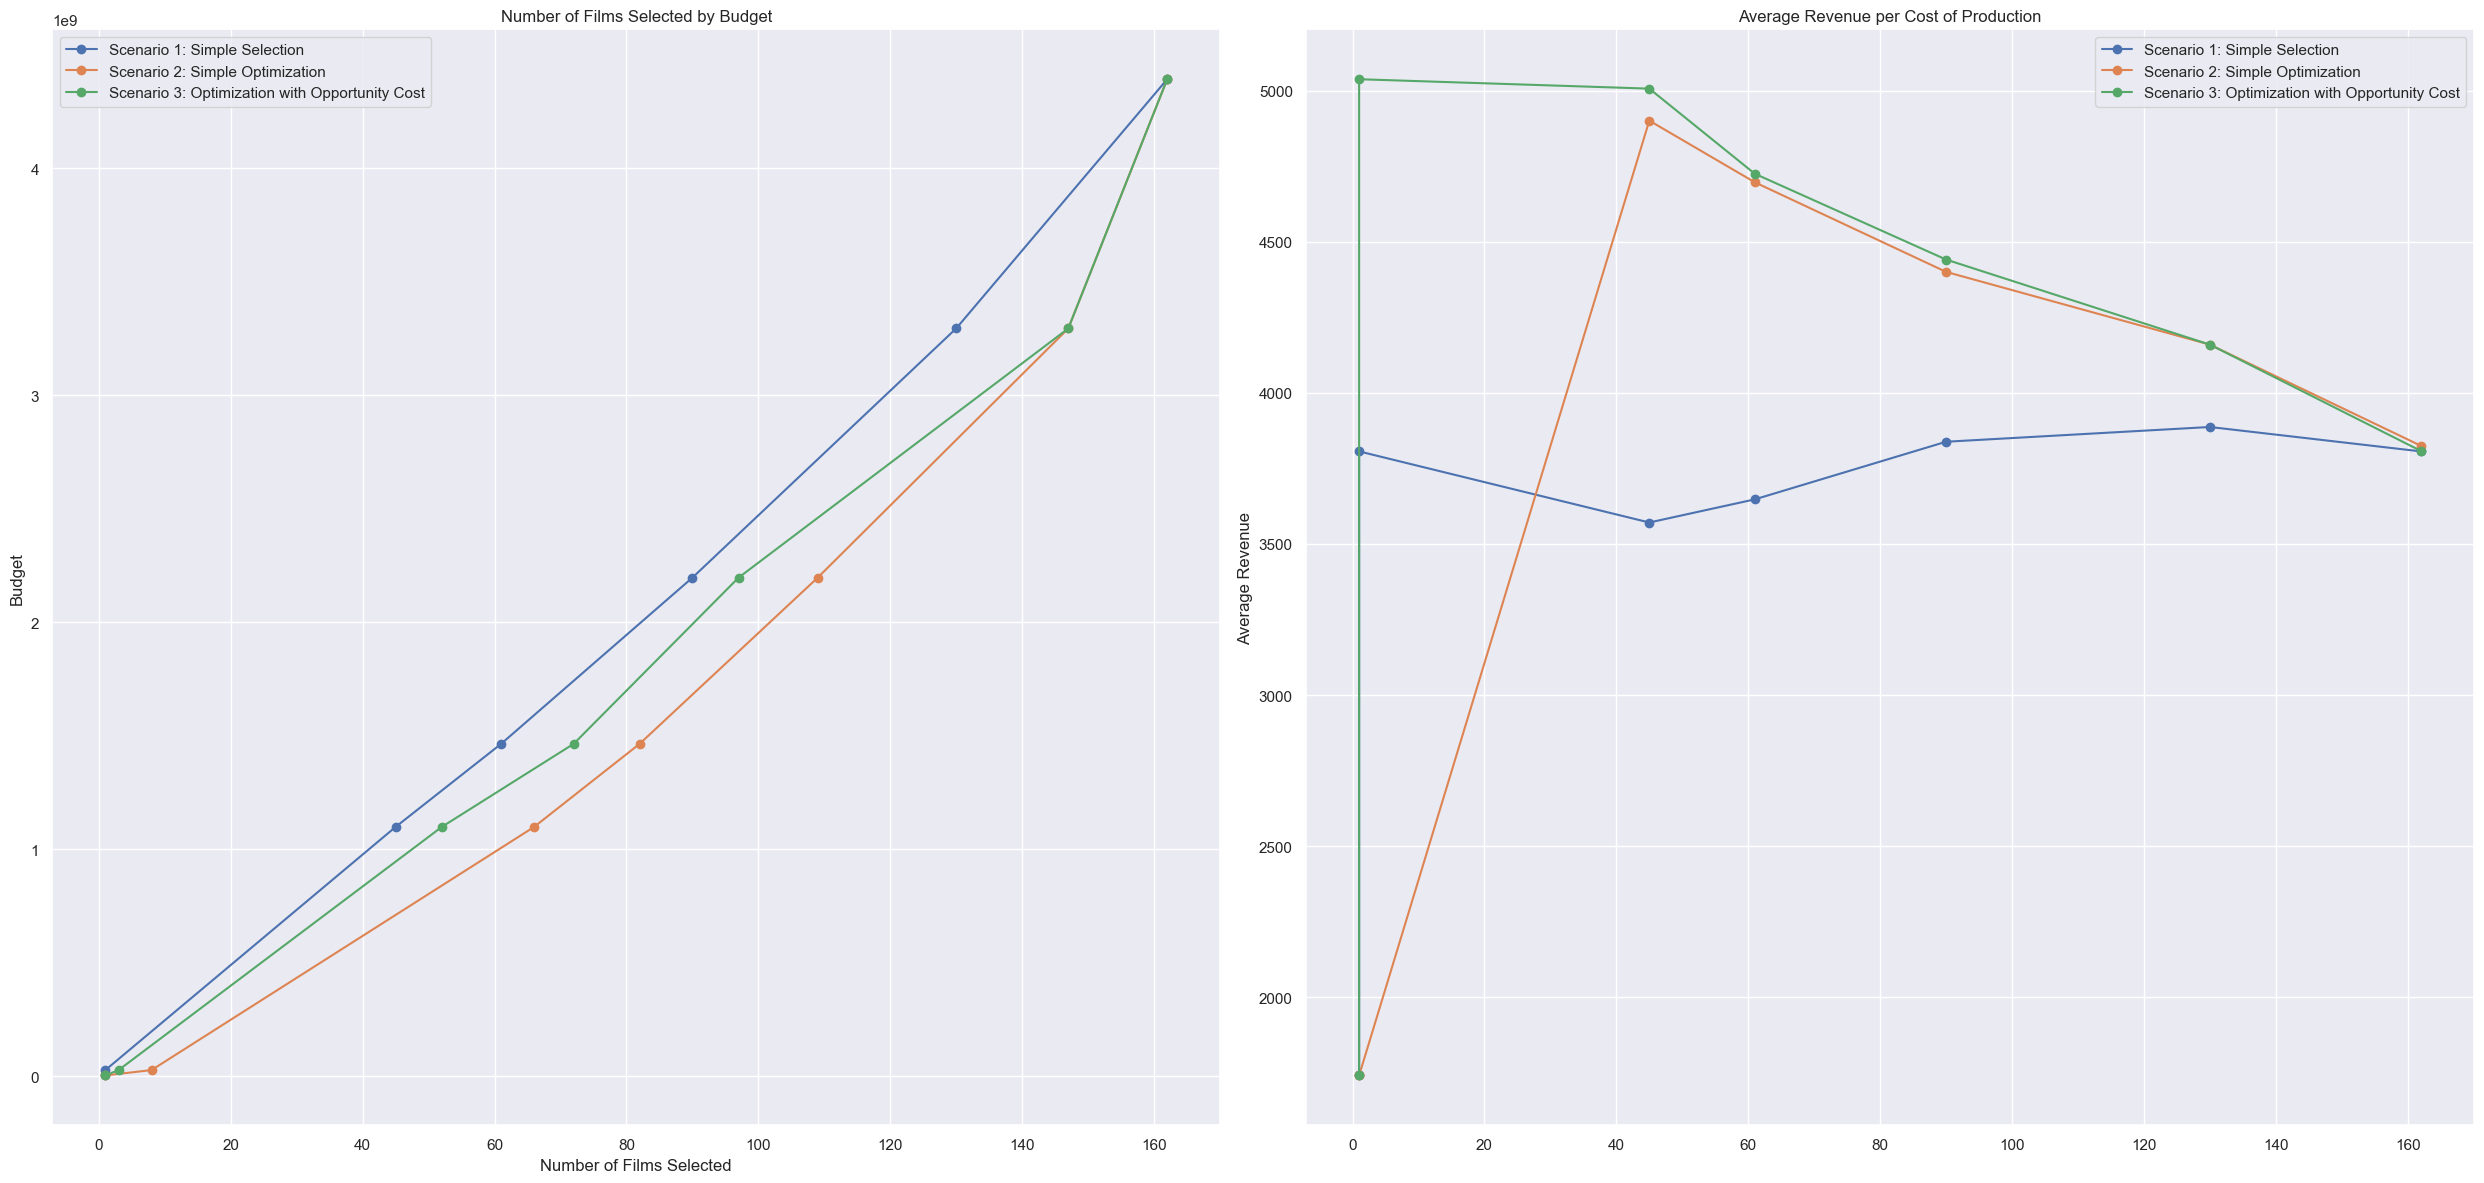

In [12]:
fig, axes = plt.subplots(1, 2)

axes[0].plot(selected_counts_c1, budget_list, label="Scenario 1: Simple Selection", marker='o')
axes[0].plot(selected_counts_c2, budget_list, label="Scenario 2: Simple Optimization", marker='o')
axes[0].plot(selected_counts_c3, budget_list, label="Scenario 3: Optimization with Opportunity Cost", marker='o')
axes[0].set_title("Number of Films Selected by Budget")
axes[0].set_xlabel("Number of Films Selected")
axes[0].set_ylabel("Budget")
axes[0].legend()
axes[0].grid(True)

axes[1].plot(selected_counts_c1, average_rate_c1, label="Scenario 1: Simple Selection", marker='o')
axes[1].plot(selected_counts_c1, average_rate_c2, label="Scenario 2: Simple Optimization", marker='o')
axes[1].plot(selected_counts_c1, average_rate_c3, label="Scenario 3: Optimization with Opportunity Cost", marker='o')
axes[1].set_title("Average Revenue per Cost of Production")
axes[0].set_xlabel("Number of Films Selected")
axes[1].set_ylabel("Average Revenue")
axes[1].legend()
axes[1].grid(True)

plt.tight_layout()
plt.show()

The graph on the left shows the budget for the number of films, so simple optimization creates the best parallel in reducing the budget per film.

The graph on the right shows the expected profit per number of films. Here, optimization has a lot of effect, as we are not only prioritizing films with a good expected rating, but also those with a good cost-return ratio. For a selection of just a few films, the opportunity cost optimization is the best, but as we get closer to 50 films, both optimizations are similar.

`Conclusion`: The data scientist doesn't make decisions, he just creates scenarios, but given the current analysis we can suggest that in a small selection of films (up to 45) it would make sense to implement opportunity cost optimization to select the best films, above 45 films we can use simple optimization to create a better relationship with a leaner budget.

## 7.3 Machine Learning Performance

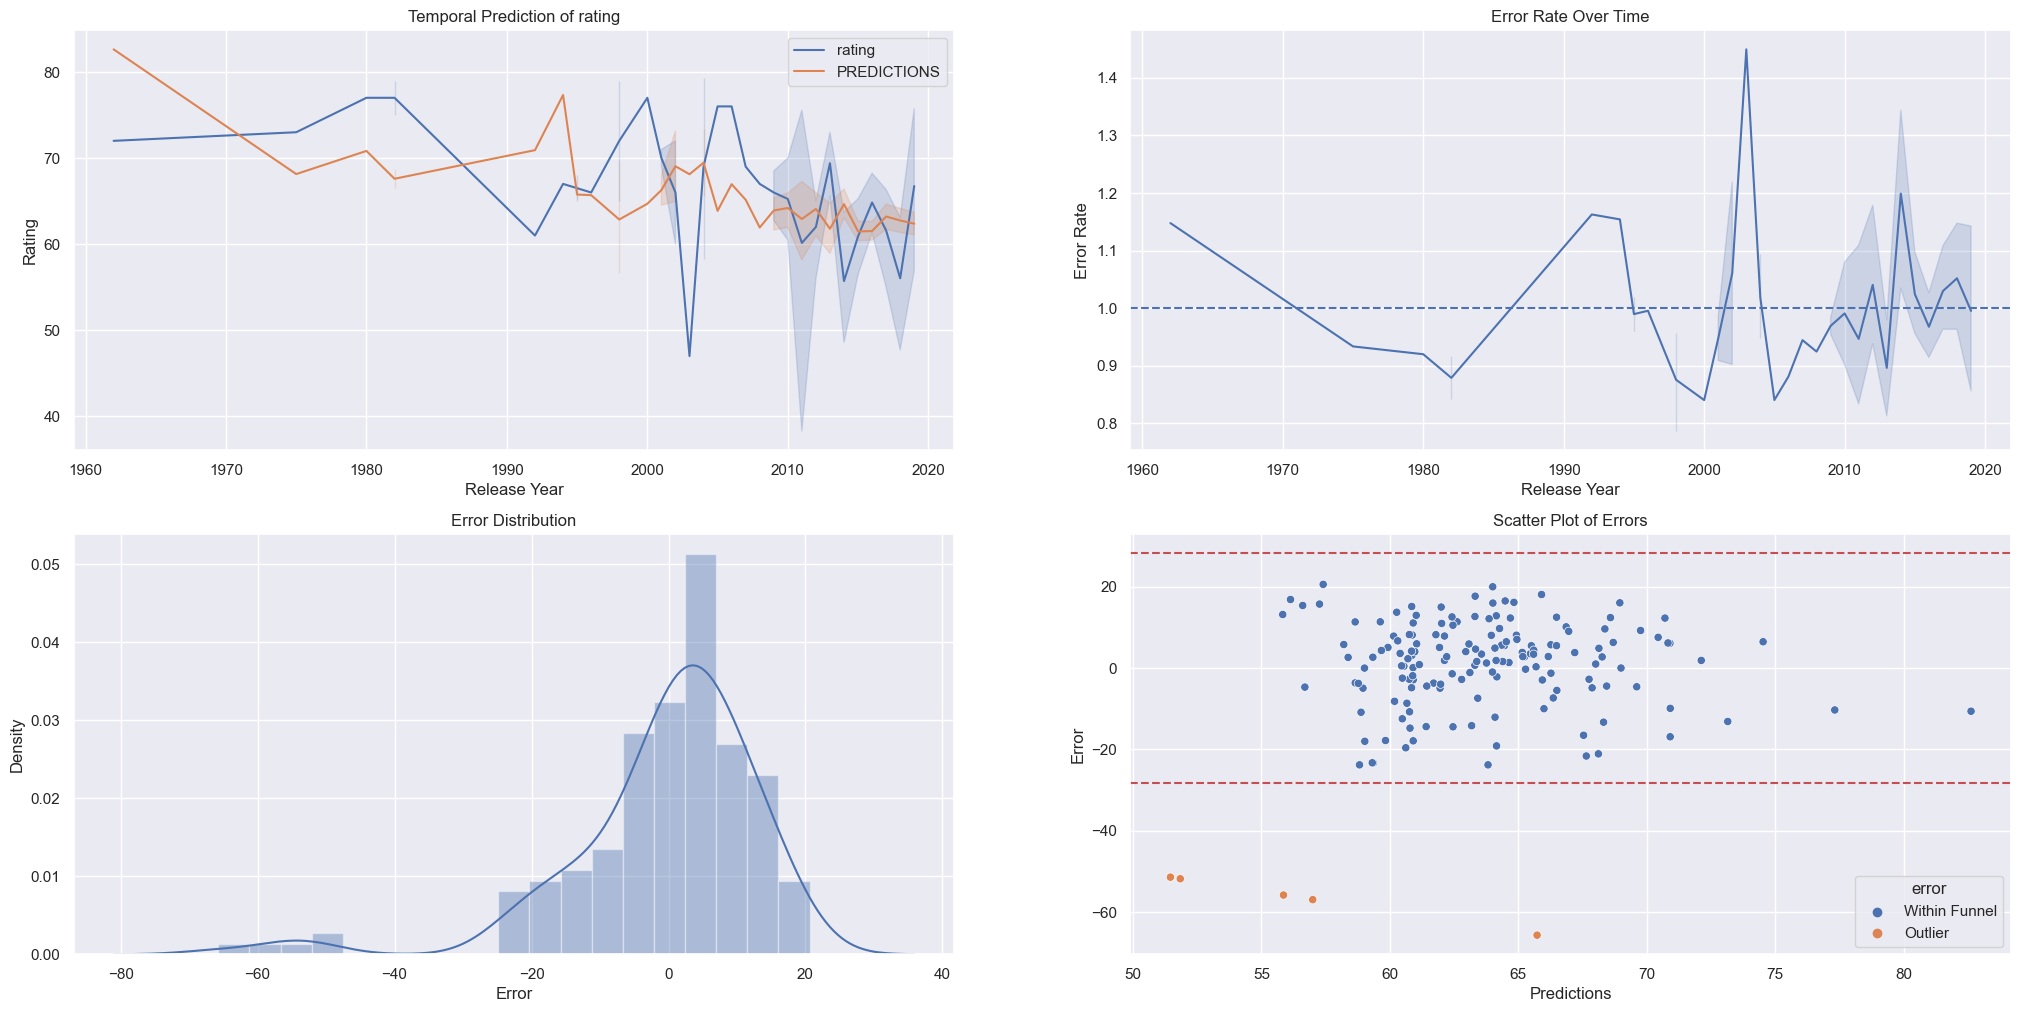

In [13]:
bussiness_scenario['error'] = bussiness_scenario['rating'] - bussiness_scenario['predictions']
bussiness_scenario['error_rate'] = bussiness_scenario['predictions'] / bussiness_scenario['rating']

plt.subplot(2, 2, 1)
sns.lineplot(x='release_year', y='rating', data=bussiness_scenario, label='rating')
sns.lineplot(x='release_year', y='predictions', data=bussiness_scenario, label='PREDICTIONS')
plt.title('Temporal Prediction of rating')
plt.xlabel('Release Year')
plt.ylabel('Rating')

plt.subplot(2, 2, 2)
sns.lineplot(x='release_year', y='error_rate', data=bussiness_scenario)
plt.axhline(1, linestyle='--')
plt.title('Error Rate Over Time')
plt.xlabel('Release Year')
plt.ylabel('Error Rate')

plt.subplot(2, 2, 3)
sns.distplot(bussiness_scenario['error'])
plt.title('Error Distribution')
plt.xlabel('Error')
plt.ylabel('Density')

plt.subplot(2, 2, 4)
# Defining the funnel
std_error = bussiness_scenario['error'].std() * 2
outliers = np.abs(bussiness_scenario['error']) > std_error
# We create a series with 'Within Funnel' and 'Outlier' as the new labels
outlier_labels = outliers.map({False: 'Within Funnel', True: 'Outlier'})
sns.scatterplot(x='predictions', y='error', hue=outlier_labels, data=bussiness_scenario)
plt.axhline(y=std_error, color='r', linestyle='--')
plt.axhline(y=-std_error, color='r', linestyle='--')
plt.title('Scatter Plot of Errors')
plt.xlabel('Predictions')
plt.ylabel('Error');

In this session we want to evaluate how the model performs, a useful moment to understand bias and focus on the next project cycles, some considerations are:

- Graph 1: Although it is not a temporal prediction, it is important to evaluate how it behaves over time to catch potential problems, for example in 1990 there was an abnormal behavior of the data, this could mean dirt, collection error or if it is reliable data then we need to analyze in the future what motivated a sudden drop in scores.
- Graph 2: The error rate should tell us that when the rate is equal to 1.0 then the prediction was perfect, here we understand that there are oscillations nearby and that in the early years the model tended to underestimate.
- Graph 3: The objective is to understand whether the distribution of errors is normal or approximate, this would highlight a non-biased model, the behavior seen is reflected in the transformation of the response variable that we applied when preparing the data and that there are small biases allowing the model to underestimate, this behavior must be taken into account when delivering the model to interested parties.
- Graph 4: Here we have the prediction errors, ideally they should be randomly distributed around error 0, the ideal situation shows errors distributed within a cone and as shown in the graph the model is managing to generalize well.